<a href="https://colab.research.google.com/github/Ness731/3-Min-Deeplearning/blob/main/Chapter.7_%EC%88%9C%EC%B0%A8%EC%A0%81%EC%9D%B8_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC_%EC%B2%98%EB%A6%AC%ED%95%98%EB%8A%94_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## __RNN(Recurrent Neural Network)__
앞서 배운 ANN, DNN, CNN, 오토인코더는 시간에 대한 개념이 없었다. 그러나 우리가 현실에서 접하는 거의 모든 데이터는 순차적(Sequential)이다. 이러한 __순차적인 데이터(시계열 데이터)__를 처리하기 위해서 고안된 신경망이 바로 RNN이다.

__| RNN :__ 정해지지 않은 길이의 데이터 배열을 순차적으로 읽고 작업을 수행하는 신경망 <br>

__| 특징__<br> 
- RNN은 __은닉벡터(hidden vector)__를 출력하며, 순차적 데이터의 흐름을 모두 내포한다.
- RNN은 어떤 시점에서의 입력값에 대한 출력값을 계산할 때, 직전 출력값을 특정 비율만큼 반영하여 연산한다. (시간개념)
<br>

__| RNN의 형태__
- __일대일__ : 한 개의 입력값에 대응하는 한 개의 출력값을 생성한다.<br>
  예) 일반적으로 보아온 신경망
- __일대다__ : 한 개의 입력값에 대해 은닉 벡터들을 통과하면서 여러 개의 출력값을 생성한다.<br>
  예) 이미지를 보고 안의 상황을 글로 설명하는 문제
- __다대일__ : 여러 개의 입력값에 대해 은닉 벡터들을 통과하면서 한 개의 출력값을 생성한다.<br>
  예) 챗봇과 기계 번역 같이 순차적인 데이터를 출력하는 문제
- __다대다__ : 여러 은닉 벡터를 통해 입력받은 값들에 대해 여러 개의 출력값을 생성한다.<br>
  예) 비디오 분류 같이 매 프레임을 레이블링하는 문제<br>

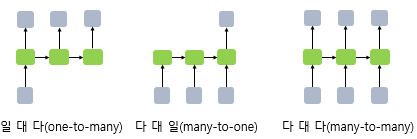

## :: 예제 - 영화 리뷰 감정 분석 ::
텍스트 형태의 데이터셋인 IMDB는 영화 리뷰(영어) 5만 건으로 이루어져있으며, 긍정적인 영화 리뷰는 2로, 부정적인 영화 리뷰는 1로 레이블링 되어있다. 이를 사용하여 영화 리뷰의 긍정/부정 여부를 판별하는 모델을 작성한다.

### __| 이슈 : 자연어 텍스트를 어떻게 학습하는가?__
자연어 텍스트를 인공 신경망에 입력시키기 위해선 __전처리 과정__을 거쳐 __데이터를 숫자로__ 나타내야 하며, 이를 __워드 임베딩(word embedding)__이라고 한다.<br>

__[워드 임베딩 과정]__
1. __토크나이징(tokenizing)__ : 문장들을 토큰(token)으로 나눈다.
2. 모든 토큰을 각각의 __벡터__로 나타낸다.
3. 모든 단어 수만큼의 벡터를 담는 __딕셔너리(dictionary)__를 정의한다.


In [1]:
!pip install -U torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 24.7 MB/s 
     |████████████████████████████████| 831.4 MB 2.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.8.0
    Uninstalling torchtext-0.8.0:
      Successfully uninstalled torchtext-0.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.0+cu113 requires torch==1.12.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.0+cu113 requires torch==1.12.0, but you have torch 1.9.0 which is incompatible.


In [5]:
# 라이브러리 import
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.legacy import data, datasets # 라이브러리 에러로 인해 구버전의 torchtext.legacy 사용

In [6]:
# 하이퍼파라미터 정의
BATCH_SIZE = 64 # 한 번의 EPOCH에서 다룰 데이터의 양
EPOCHS = 40     # 이터레이션 횟수
lr = 0.001
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

### __워드 임베딩하기__

In [7]:
# 1. 토치텍스트를 이용하여 임베딩 설정 정보를 담은 객체를 생성한다.
# sequential: 순차 데이터 여부, lower: 소문자 처리 옵션
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True)

In [8]:
# 2. 토크나이징을 통해 모델에 입력되는 학습, 테스트 데이터셋을 만들어준다.
trainset, testset=  datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:08<00:00, 9.51MB/s]


In [14]:
# 3. 토큰을 담는 딕셔너리를 생성한다.
TEXT.build_vocab(trainset, min_freq=5)
LABEL.build_vocab(trainset)

In [15]:
# 검증 데이터셋을 추가한다.
trainset, valset = trainset.split(split_ratio=0.8) # 2:8의 비율로 분할한다.
train_iter, val_iter, test_iter = data.BucketIterator.splits((trainset, valset, testset), batch_size=BATCH_SIZE, shuffle=True, repeat=False)

In [16]:
vocab_size = len(TEXT.vocab) # 딕셔너리 사이즈 (모든 토큰 개수)
n_classes = 2 # 레이블 개수 (긍정/부정)

In [17]:
print("[학습 데이터셋]: %d, [검증 데이터셋]: %d, [테스트 데이터셋]: %d, [단어 수]: %d, [레이블 수]: %d" % (len(trainset), len(valset), len(testset), vocab_size, n_classes))

[학습 데이터셋]: 20000, [검증 데이터셋]: 5000, [테스트 데이터셋]: 25000, [단어 수]: 46159, [레이블 수]: 2


###__RNN 모델 구현하기__
본 순환신경망 모델에서는 RNN 대신에 GRU를 사용한다. RNN을 사용하면 문장의 뒷부분에 다다를수록 앞부분의 정보가 소실되는 __장기의존성 문제__가 발생하기 때문이다.<br>

__| 장기의존성 문제__ <br>
RNN에서 입력이 길어지면 학습 도중 기울기가 너무 작아지거나(경사도 소실) 커져서(경사도 폭발) 앞부분에 대한 정보를 정확히 담지 못하는 현상.<br>

-> GRU에서는 이러한 문제를 해결하기 위해 순차적 데이터 사이의 정보 전달량을 조절함으로써 기울기를 적정하게 유지하고 문장 앞부분의 정보가 끝까지 도달할 수 있도록 한다.

In [ ]:
class BasicGRU(nn.Module):
  def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
    super(BasicGRU, self).__init__()
    print("Building Basic GRU model...")
    
    # ***순환신경망 정의를 위해 필요한 파라미터***
    self.dropout = nn.Dropout(dropout_p)
    # 은닉벡터들의 층
    self.n_layers = n_layers
    # 은닉벡터의 차원값
    self.hidden_dim = hidden_dim
    # 임베딩할 단어들의 총 개수, 임베딩된 단어 텐서가 지니는 차원값을 입력받아 임베딩하는 함수
    self.embed = nn.Embedding(n_vocab, embed_dim)

    # ***순환신경망으로 GRU를 사용***
    self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=self.n_layers, batch_first=True)

    # 분류층(fc레이어)
    self.out = nn.Linear(self.hidden_dim, n_classes)


  def forward(self, x): # x: 입력데이터
    x = self.embed(x) # 입력 데이터는 자연어 텍스트이므로 임베딩한다.
    h_0 = self._init_state(batch_size=x.size(0)) # 첫 번째 은닉벡터는 이전 은닉벡터(t-1)가 없으므로, 별도의 정의가 필요하다.


  def _init_state(self, batch_size=1): # 첫 번째 은닉벡터를 정의하는 함수
    weight = next(self.parameters()).data
    return weight.new(self.n_layers, batch_size, self.hidden_dun).zero_()